## Import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read CSV

In [5]:
data_path_1min = "../data/household_data_1min_singleindex.csv"
data_path_15min = "../data/household_data_15min_singleindex.csv"
data_path_60min = "../data/household_data_60min_singleindex.csv"
data = pd.read_csv(data_path_60min)

In [6]:
data

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,interpolated
0,2014-12-11T17:00:00Z,2014-12-11T18:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-11T18:00:00Z,2014-12-11T19:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-11T19:00:00Z,2014-12-11T20:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-11T20:00:00Z,2014-12-11T21:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-11T21:00:00Z,2014-12-11T22:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38449,2019-05-01T18:00:00Z,2019-05-01T20:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38450,2019-05-01T19:00:00Z,2019-05-01T21:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38451,2019-05-01T20:00:00Z,2019-05-01T22:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38452,2019-05-01T21:00:00Z,2019-05-01T23:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
column_names = data.columns.tolist()
column_names

['utc_timestamp',
 'cet_cest_timestamp',
 'DE_KN_industrial1_grid_import',
 'DE_KN_industrial1_pv_1',
 'DE_KN_industrial1_pv_2',
 'DE_KN_industrial2_grid_import',
 'DE_KN_industrial2_pv',
 'DE_KN_industrial2_storage_charge',
 'DE_KN_industrial2_storage_decharge',
 'DE_KN_industrial3_area_offices',
 'DE_KN_industrial3_area_room_1',
 'DE_KN_industrial3_area_room_2',
 'DE_KN_industrial3_area_room_3',
 'DE_KN_industrial3_area_room_4',
 'DE_KN_industrial3_compressor',
 'DE_KN_industrial3_cooling_aggregate',
 'DE_KN_industrial3_cooling_pumps',
 'DE_KN_industrial3_dishwasher',
 'DE_KN_industrial3_ev',
 'DE_KN_industrial3_grid_import',
 'DE_KN_industrial3_machine_1',
 'DE_KN_industrial3_machine_2',
 'DE_KN_industrial3_machine_3',
 'DE_KN_industrial3_machine_4',
 'DE_KN_industrial3_machine_5',
 'DE_KN_industrial3_pv_facade',
 'DE_KN_industrial3_pv_roof',
 'DE_KN_industrial3_refrigerator',
 'DE_KN_industrial3_ventilation',
 'DE_KN_public1_grid_import',
 'DE_KN_public2_grid_import',
 'DE_KN_resid

In [28]:
data["utc_timestamp"] = pd.date_range(start="2014-12-11T17:59:00Z", periods=len(data), freq="min")
data.shape
data

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,interpolated
0,2014-12-11 17:59:00+00:00,2014-12-11T18:59:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-11 18:00:00+00:00,2014-12-11T19:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-11 18:01:00+00:00,2014-12-11T19:01:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-11 18:02:00+00:00,2014-12-11T19:02:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-11 18:03:00+00:00,2014-12-11T19:03:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307128,2019-05-01 22:07:00+00:00,2019-05-02T00:07:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2307129,2019-05-01 22:08:00+00:00,2019-05-02T00:08:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2307130,2019-05-01 22:09:00+00:00,2019-05-02T00:09:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2307131,2019-05-01 22:10:00+00:00,2019-05-02T00:10:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean data

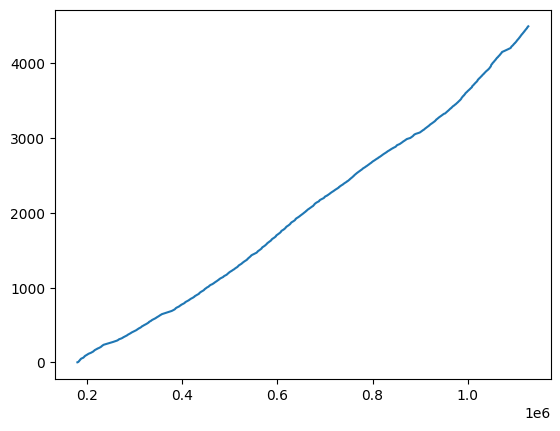

In [29]:
plt.plot(data.DE_KN_residential2_grid_import)